In [ ]:
# default_exp model
%load_ext lab_black
# nb_black if running in jupyter
%load_ext autoreload
# automatically reload python modules if there are changes in the
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# Model

> In this notebook you create and test a Python class to hold your machine learning model.

***input***: toy dataset from data-notebook

***output***: ML model / simulation / analytics python module

***description:***

In this notebook you hypothetize, explain and explore machine learning models to solve your problem.

Then, you should encapsulate the model inside a Python class to be exported into `your_repo_name/model.py`,
so that it can be evaluated in the loss notebook, and intergrated with your target application.
You should also unit test the classes created in this notebook with the toy data created in data notebook.

You should probably have a person in your team familiar with object oriented programming with python and unit testing, but if not, don't worry.
If you can draft the model function in a script format, any programmer can easily do it for you.
However, we encourage you to learn more on [object oriented programming with Python](https://realpython.com/python3-object-oriented-programming/)
and [getting started with unit testing in Python](https://realpython.com/python-testing/).

This notebook contains an example ML model for classifying the heart disease dataset with linearregression.

If the methods are complicated or you are comparing multiple methods that are inheritantly different by nature, 
you can also separate models or subclasses to different notebooks similar to this.
Adjust the running number, name, header and top cell `#default_exp module_name` of the notebooks accordingly.

Remember to add `# export` to top of all cells containing functions or classes that you have defined and want to use outside this notebook.




## Import relevant modules

In [ ]:
# export
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    train_test_split,
    StratifiedKFold,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# import custom modules
from ml_project_template.data import plot_trellis, plot_histogram

## Define parameters

Remember, only simple assignments here!

In [ ]:
# tag this cell with 'parameters'
seed = 0

Make immediate derivations from the parameters:

In [ ]:
np.random.seed(0)

## Import toy data for testing

In [ ]:
toy_df = pd.read_csv(
    "data/preprocessed_data/dataset_toy_switzerland_cleveland.csv", index_col=0
)
toy_df.head()

,x1age,x4trestbps,x8thalach,x10oldpeak,y1num
0,53.0,142.0,111.0,0.0,0
1,56.0,200.0,133.0,4.0,1
2,62.0,140.0,143.0,0.0,1
3,53.0,160.0,122.0,0.0,1
4,54.0,160.0,163.0,0.0,0


## Begin with a simple script before constructing the model class

Scripting is a way of programming most people doing research are used to.
In a script, everything a code does is written in a file (or for example notebook cell),
and the rows are executed in order.

Of course you can define complicated objects and functions in a script,
and in fact most modern programming languages are written in a script like way.
So you are used to this, and there is nothing new here!

Here we define the following steps
1. Splitting data into training and testing data
2. Preprocess the data (e.g. scale, dimension reduction)
3. Fit a model
4. Turn steps 2 and 3 into a pipe
5. Optimize hyperparameters

By defining these, we get a pretty good picture of required properties of our ML model class!


In [ ]:
# split train and test data

X = toy_df.iloc[:, :-1]  # .to_numpy()
y = toy_df.iloc[:, -1]  # .to_numpy()

k = 2
seed = 0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 / 5, random_state=seed, stratify=y
)

In [ ]:
# create preprocessing steps, model and pipe

scaler = StandardScaler()
lgr = LogisticRegression()
pipe = Pipeline([("scaler", scaler), ("estimator", lgr)])
pipe.fit(
    X_train,
    y_train,
)
print(pipe.score(X_test, y_test))

0.4


In [ ]:
# create optimization pipe

cv = StratifiedKFold(n_splits=k)
print(cross_val_score(pipe, X_train, y_train, cv=cv))

## optimize
param_grid = {
    "estimator__C": np.logspace(-4, 4, 10),
}

# make_pipeline(Imputer(),StandardScaler(),PCA(n_components=2),SVC(random_state=1))

# cv = StratifiedKFold(n_splits=5)
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    return_train_score=True,
)
gs.fit(X_train, y_train)

print("Best Estimator: \n{}\n".format(gs.best_estimator_))
print("Best Parameters: \n{}\n".format(gs.best_params_))
print("Best Test Score: \n{}\n".format(gs.best_score_))
print(
    "Best Training Score: \n{}\n".format(
        gs.cv_results_["mean_train_score"][gs.best_index_]
    )
)
print("All Training Scores: \n{}\n".format(gs.cv_results_["mean_train_score"]))
print("All Test Scores: \n{}\n".format(gs.cv_results_["mean_test_score"]))
# # This prints out all results during Cross-Validation in details
# print("All Meta Results During CV Search: \n{}\n".format(gs.cv_results_))

# Reset pipeline with best params
pipe.set_params(estimator__C=gs.best_params_["estimator__C"])
pipe.fit(X_train, y_train)
print("Test score with best params (should equal to Best Test Score above)")
print(pipe.score(X_test, y_test))

[0.7 0.8]
Best Estimator: 
Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator', LogisticRegression(C=2.782559402207126))])

Best Parameters: 
{'estimator__C': 2.782559402207126}

Best Test Score: 
0.65

Best Training Score: 
0.9

All Training Scores: 
[0.6 0.6 0.6 0.6 0.9 0.9 1.  1.  1.  1. ]

All Test Scores: 
[0.6  0.6  0.6  0.6  0.65 0.65 0.5  0.5  0.5  0.5 ]

Test score with best params (should equal to Best Test Score above)
0.4


Ok, so we can fit a model to the data and it appears to do something (with the small test data we can not necessarily say if it's meaningful).

However, how would you take this script into production?
How would you scale it, or use it with completely different setup of data and parameters?
(well, this is a tiny example, so we could actually easily parameterize a script, but that's rarely the case in real world applications)

This is why we need to construct a model class, to hold all of the steps required in separate, tidy functions.
Then we can recreate the model and the steps with different data, without copy-pasting or manually editing all the tiny details.

## Define base class for your ML model

You will probably do just fine creating a one simple class that does not inherit anything.
You can then use this example base class as a template for your machine learning class. 
However, this is not always the case, and class inheritance is one of the most useful features of Python (and object oriented programming).
This is why we wanted to demonstrate a base class - subclass division.

Here we define the base class `MachineLearningModel` that holds some simple functions for handling data, that would be common for all subclasses.
If a function only contains a `pass`-statement, it will be defined in the subclass.

> **Note**: in this example the model instance contains the data. 
This is rarely applicable in practice if the data is large.
Instead, in most applications the model should be routed to query the data when needed, in a similar way that it would appear as if the model instance contained the data.  

In [ ]:
# export

# Define base class for our classifier
class MachineLearningModel:
    """
    Overly simplified example for a base class: basically just function handle definitions
    """

    def __init__(self, X, y, n_splits=5, seed=0):
        self.n_splits = n_splits  # k-fold n_splits
        self.seed = seed
        self.set_data(X, y)

    def set_data(self, X, y):
        """
        Set traing and evaluation data
        """
        self.X = X.copy()
        self.y = y.copy()

        self.__create_train_test_data()

        return self

    def get_data(self) -> (np.ndarray, np.ndarray):
        """
        Get training and evaluation data
        """
        return self.X.copy(), self.y.copy()

    def __create_train_test_data(self, n_splits=None, seed=None):
        """
        Create training and testing data
        """
        if seed is None:
            seed = self.seed
        if n_splits is None:
            n_splits = self.n_splits

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=(1 / n_splits), random_state=seed, stratify=self.y
        )

        return self

    def get_train_test_data(self):
        """
        Return X_train, X_test, y_train, y_test
        """
        return self.X_train, self.X_test, self.y_train, self.y_test

    def fit(self, X=None, y=None, **fit_params):
        pass

    def predict(self, X):
        pass

    def loss(self, X, y):
        pass

    def get_train_loss(self):
        pass

    def get_test_loss(self):
        pass

    def optimize(self):
        pass

    def get_params(self):
        pass

## Unit test base class

Purpose of unit testing is to cover all possible excecution paths in code.
Unit testing helps developers to avoid and identify bugs in code.

To unit test the class, we want to try and call every function of it and execute every different possible execution path.
The proportion of possible paths covered is called the test coverage.
100% coverage is rarely possible,
but it would be good to try and test the functions with good and bad input,
and with possible limit values (min, max, zero, None, np.nan, empty list etc.).

However, a few simple tests are easier to maintain (and to actually get done) than exhaustive unit testing, so don't worry about coverage too much!


At the moment, nbdev considers all cells that do not have `# export` tag as tests.
Unit tests can be defined with `assert` command - the nbdev git hooks run these commands when you push commits.
Cells with `# slow` -tag will be omitted for time savings.

The line after `assert` should have a `True` or non-zero value.
`False`, 0 or None object will raise an `AssertionError`. Note that `np.nan` does not raise the error.

This is handy because you can now keep all your tests in the same file (notebook) with the code and documentation.
The downside is, however, that at the moment there is no good solution for monitoring test coverage of notebook developed code. 
If test coverage measuring is required, one option would be to implement tests with  `pytest` or `unittest` and export the tests to separate test.py file.



In [ ]:
# Example of a simple unit test
this_statement_is_true = True
assert this_statement_is_true

# Another example of simple unit test of a function
def return_three():
    return 3


assert return_3() == 3

# Third example of simple unit testing of a simple class
class SimpleClass:
    """
    Simple class that stores an attribute and has a function to return it
    """

    def __init__(self, parameter):
        self.attribute = parameter

    def get_attribute(self):
        return self.attribute


# unit thest init (should return class instance)
assert SimpleClass("hello world!")
# unit test get_attribute (should return 'Hello world!')
assert SimpleClass("Hello world!").get_attribute() == "Hello world!"

If the assert commands run without an error, the tests pass.

Now, let's include some tests with our example ML base class:

In [ ]:
# test init
assert MachineLearningModel(X, y)

mlmodel = MachineLearningModel(X, y)

# test get_data
assert mlmodel.get_data()[0].shape == X.shape
assert mlmodel.get_data()[1][1] == y[1]

# test __create_test_train_data and get_train_test_data
assert np.ceil(
    10 * mlmodel.get_train_test_data()[-1].shape[0] / mlmodel.get_data()[1].shape[0]
) == np.ceil(10 / mlmodel.n_splits)

# test set_data
assert (
    MachineLearningModel(X, y)
    .set_data(X.iloc[range(X.shape[0] - 1, -1, -1)], y)
    .get_data()[0]
    .iloc[0, 0]
) == X.iloc[-1, 0]

## Define subclasses & functions

A subclass or child class inherits all attributes and functions of a parent class, but may also have additional functions defined.

Here we define an example of a subclass of `MachineLearningModel`, the `LogisticRegressionModel` which performs logistic regression:

In [ ]:
# export

# Create subclass
# now you see, that the subclass inherits data handling functions from the base class,
# and we do not need to redefine them (although we could if we wanted to!


class LogisticRegressionClassifier(MachineLearningModel):
    """
    Logistic regression classifier
    """

    def __init__(self, X, y, n_splits=5, seed=0):

        super(LogisticRegressionClassifier, self).__init__(
            X, y, n_splits=n_splits, seed=seed
        )

        self.scaler = StandardScaler()
        self.model = LogisticRegression()
        self.pipe = Pipeline([("scaler", self.scaler), ("estimator", self.model)])

        # cross validation for optimization
        self.cv = StratifiedKFold(n_splits=self.n_splits)

        # param grid for optimization
        self.param_grid = {
            "estimator__C": np.linspace(0.3, 1.7, 10)  # logspace(-4, 4, 10),
        }

        # define optimization method for optimizing the model
        self.optimization_pipe = GridSearchCV(
            estimator=self.pipe,
            param_grid=self.param_grid,
            scoring="accuracy",
            cv=self.cv,
            return_train_score=True,
        )

    def fit(self, X=None, y=None):
        """
        Train and evaluate model
        """
        if X is None or y is None:
            self.pipe.fit(self.X_train, self.y_train)
        else:  # reset data, recreate training and testing data and recursively call fit
            self.set_data(X, y).fit()

        return self

    def predict(self, X):
        """
        Get predicted value at X
        """
        return self.pipe.predict(X)

    def loss(self, X, y):
        """
        Return loss (model quality metric) [f1 score]

        Note that this may be a different metric than the one that the model optimizer is using (scoring method).
        For example for LogisticRegression the scoring method is mean accuracy,
        but we want to track f1-score for loss because it is better balanced.
        """

        return f1_score(y, self.predict(X))

    def get_train_loss(self):
        """
        Return loss for training data
        """
        return self.loss(self.X_train, self.y_train)

    def get_test_loss(self):
        """
        Return loss for testing data
        """
        return self.loss(self.X_test, self.y_test)

    def optimize(self):
        """
        Optimize model hyperparameters and fit the model with optimized parameters.

        This example is with GridSearchCV, but more efficient algorithms can be implemented in practice.
        """
        self.optimization_pipe.fit(self.X_train, self.y_train)
        self.pipe.set_params(
            estimator__C=self.optimization_pipe.best_params_["estimator__C"]
        )
        self.fit()
        return self

    def get_params(self):
        """
        Return parameters
        """
        return self.pipe.get_params()

## Unit test subclasses

In [ ]:
# test init
assert LogisticRegressionClassifier(X, y)
lgr_model = LogisticRegressionClassifier(X, y)

# test fit
try:  # fit should be called before predict or score
    lgr_model.predict([1, 1, 1, 1])  # so this will cause an error
except:  # but the except statement catches the error
    pass  # yes, you can also test what should not work!

# there are two ways we can call the fit function: with and without data
assert lgr_model.fit()
assert lgr_model.fit(X, y) 

# test predict
assert lgr_model.predict(X[::1]).any()
# test loss
assert lgr_model.get_train_loss()
assert lgr_model.get_test_loss()

# test get_params
assert lgr_model.get_params()

Before optimization
predicted: [1 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0]
true     : [0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1]
train_loss: 0.8695652173913043	test_loss: 0.5714285714285715
After optimization:
predicted: [1 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0]
true     : [0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1]
train_loss: 0.8695652173913043	test_loss: 0.5714285714285715


In addition, we could observe that our model is super slow.
Then, we could try to evaluate how much time each of the functions,
and even the contents of the functions take to identify the bottlenecks.
The theory of [order of functions](https://en.wikipedia.org/wiki/Big_O_notation) may also be useful.

However, this is something you should only do in the late stages of your project.
Remember, thinking time is what matters in data science!
Begin with overoptimizing things, and you'll never have results.

Anyway, you can easily time functions in notebooks with `%%timeit` [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html):


In [ ]:
# slow
%%timeit
LogisticRegressionClassifier(X, y)

1.22 ms ± 599 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Visualize model behaviour with toy data

Now, with the unit tests we can assume that our model does something right.
At least any of the functions do not crash with expected input.

As with the data preparation, the last step is to visualize the model performance.
With small sample data, we may not see anything interestin,
but sometimes already small number of datapoints can reveal interesting properties of the model when visualized.

You can also define functions for visualizing the model performance, and export them to the model module,
or include them directly as part of your machine learning model class if you see benefits from it.
Either way, it's better to test them too with the toy data before the real deal!


Quite often we would like to see how a model performs when the number of data is increased.
The two common questions are:

1. How much data is needed that the model is accurate?

2. How much data we can put in the model and still be able to run it with our resources?

Then, we might have to balance between these two.



So, for our example, let's loop through a range of data points, fit and time the model at each round

In [ ]:
import time # library for checking time
lgr = LogisticRegressionClassifier(X, y)

# dataframe to save results
eval_df = pd.DataFrame()

for i in range(10, X.shape[0]):
    lgr.fit(X.iloc[:i], y.iloc[:i])

    begin = time.time() # measure time before model is optimized
    lgr.optimize()
    end = time.time() # measure time after optimization

    ret = pd.DataFrame(
        {
            "round": [i - 10],
            "n_obs": [lgr.get_data()[0].shape[0]],
            "train_loss": [lgr.get_train_loss()],
            "test_loss": [lgr.get_test_loss()],
            "optimized_C": [lgr.get_params()["estimator__C"]],
            "optimization_time": end - begin, # time spent in optimization
        }
    )
    eval_df = pd.concat([eval_df, ret], axis=0, ignore_index=True)
eval_df.set_index("round", inplace=True)
eval_df.head()

/anaconda/envs/templateenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/anaconda/envs/templateenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/anaconda/envs/templateenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/anaconda/envs/templateenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only 

,n_obs,train_loss,test_loss,optimized_C,optimization_time
round,,,,,
0,10,0.769231,0.666667,0.3,0.555506
1,11,0.769231,0.800000,0.3,0.546714
2,12,0.769231,0.800000,0.3,0.522048
3,13,0.800000,0.800000,0.3,0.519283
4,14,0.833333,0.500000,0.3,0.518505


As we can see, the stratification gives some warnings with such a small test set.

Now you can also visualize the results. Super simple example:

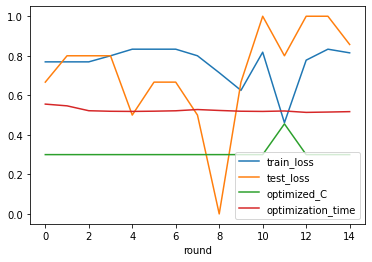

In [ ]:
_ = eval_df.drop("n_obs", axis=1).plot()

Well, as suspected it's hard to draw much conclusions from using the model with this little data.

At the third round it appears that the model makes every single test prediction wrong (f1 score 0), which is actually quite rare result. 
At least the optimization time appears quite stable between the rounds.

## Output of this notebook

The result of this notebook is a collection methods ready for evaluation with the real data.

the methods should be exported with `nbdev_build_lib`, but in the future this will be automatically handled by the pipeline

## You can move on to loss notebook!